In [1]:
# uses conda environment gpflow6_0

# generic
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import time

# plotting
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from shapely import geometry
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D 
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import gpflow as gpf
from gpflow.ci_utils import ci_niter, ci_range
from gpflow.utilities import print_summary

# tensorflow
import tensorflow as tf

#debug
from IPython.core.debugger import set_trace

from eu_functions import *
import os
import warnings; warnings.simplefilter('ignore')

In [4]:
####################  Initialize parameters #######################

ice_model = 'd6g_h6g_' # "d6g_h6g_"
lith = 'l96C'
tmax = 12000
tmin = 100
agemax = round(tmax, -3) + 100
agemin = round(tmin, -3) 
place = 'northsea_uk'

north_england = 'red'
denmark_netherlands = 'orange'
english_channel = 'blue'
northsea_uk_tight = 'purple'

ages = np.arange(agemin, agemax, 100)[::-1]

locs = {
        'northsea_uk_wide': [-15, 25, 45, 60],
        'northsea_uk': [-10, 10, 45, 60],
        'northsea_uk_tight': [-5, 10, 48, 57],
        'english_channel': [-5, 2, 48, 52],
        'denmark_netherlands': [3, 10, 52, 56],
        'north_england':[-5, 2.5, 53, 56],
        'europe_arctic': [-15, 88, 45, 85],
        
       }
extent = locs[place]

##Get Norway data sheet from Google Drive
sheet = 'Norway_isolation'
path = '../../data/holocene_fennoscandian_data_05132020.csv'

df_nor = load_nordata_fromsheet(sheet, path, fromsheet=False)

# Get Barnett data
path = f'../../data/SciAdv_Barnett_SupplementaryDataset_S1_long.csv'
df_barnett = import_barnett2020(path)

#import khan dataset
path = '../../data/GSL_LGM_120519_.csv'
df_place = import_rsls(path, df_nor, df_barnett, tmin, tmax, extent)

# add zeros at present-day.  
nout = 50
df_place = add_presday_0s(df_place, nout)



#####################  Make xarray template  #######################

filename = '../../data/xarray_template.mat'
ds_template = xarray_template(filename, ages, extent)

####################    Load GIA datasets   #######################
path = f'../../data/{ice_model}/output_{ice_model}{lith}'
ds = make_mod(path, ice_model, lith, ages, extent)

likelist = []
namelist = []
wrsslist = []
rmselist = []
wrmselist = []

ds_load = ds.load().chunk((-1,-1,-1)).interp(lon=ds_template.lon, lat=ds_template.lat).to_dataset()

# for speed, just select 2
ds_load = ds_load.sel(modelrun=['d6g_h6g_l96C_ump4_lm50', 
                                'd6g_h6g_l96C_ump4_lm40',
#                                 'd6g_h6g_l71C_ump5_lm20',
#                                 'd6g_h6g_l71C_ump2_lm9',
#                                 'd6g_h6g_l71C_ump4_lm30', 
#                                 'd6g_h6g_l71C_ump4_lm20',
#                                 'd6g_h6g_l71C_ump5_lm15', 
#                                 'd6g_h6g_l71C_ump4_lm7',                   
#                                 'd6g_h6g_l71C_ump5_lm50', 
                                'd6g_h6g_l96C_ump3_lm5',
                               ])

In [3]:
path = f'../../data/NWEuropeLIGDatabase_v4.csv'
df_lig = pd.read_csv(path, header=1)
df_lig.rename(columns={'Longitude':'lon',
                        'Latitude':'lat',
                        'Relative Sea \nLevel (m)':'rsl',
                        'RSL Error \n(1σ m)':'rsl_er',
                        'Age\n(ka BP)':'age',
                      'Age Error\n(1σ ka)':'age_er'}, inplace=True)

df_lig = df_lig[(df_lig.lon > extent[0])
               & (df_lig.lon < extent[1])
               & (df_lig.lat > extent[2])
               & (df_lig.lat < extent[3])]

In [258]:
# #####################    Run Iterative GP Regression   ##################

# for i, ds_single in ds_load.groupby('modelrun'):

#     #interpolate/select priors from GIA model
#     df_place['rsl_giaprior'] = df_place.apply(lambda row: ds_select(ds_single, row), axis=1)
#     df_place['age_giaprior'] = df_place.apply(lambda row: ds_ageselect(ds_single, row), axis=1)
    
#     #calculate residuals
#     df_place['rsl_realresid'] = df_place.rsl - df_place.rsl_giaprior
#     df_place['age_realresid'] = df_place.age - df_place.age_giaprior
# #     df_place['rsl_realresid_rmse'] = df_place.rsl - df_place.rsl_giaprior
    
#     # Calculate weighted root mean squared error and weighted residual sum of squares
#     df_place['wrss'] = (df_place.age_realresid/df_place.age_er)**2 + (df_place.rsl_realresid/df_place.rsl_er)**2
    
#     wrss = df_place.wrss.sum()
    
#     weights = df_place.rsl_er/df_place.rsl_er.sum()
#     rmse = np.sqrt((df_place.rsl_realresid ** 2).sum()/len(df_place))
#     wrmse = np.sqrt((df_place.rsl_realresid ** 2/weights).sum()/len(df_place))

    
#     print('number of datapoints = ', df_place.shape)
    
#     ##################	  RUN GP REGRESSION 	#######################
#     ##################  --------------------	 ######################


#     k1 = 50
#     k2 = 10000
#     k3 = 5000
#     k4 = 10000

#     iterations = 1000
#     nout = 40
#     name = ds_single.modelrun.values.tolist()[0]

#     ds_giapriorinterp, da_zp, ds_priorplusgpr, ds_varp, loglike, m, df_place = run_gpr(nout, iterations, ds_single, ages, k1, k2, k3, k4, df_place)
    
#     likelist.append(loglike)
#     namelist.append(name)
#     wrsslist.append(wrss)
#     rmselist.append(rmse)
#     wrmselist.append(wrmse)
    
#     path_gen = f'output/{place}_{name}_{ages[0]}_{ages[-1]}'
#     da_zp.to_netcdf(path_gen + '_dazp')
#     ds_giapriorinterp.to_netcdf(path_gen + '_giaprior')
#     ds_priorplusgpr.to_netcdf(path_gen + '_posterior')
#     ds_varp.to_netcdf(path_gen + '_gpvariance')
    
#     # calculate posterior RMSE
#     df_place['rsl_posterior'] = df_place.apply(lambda row: ds_select(ds_priorplusgpr, row), axis=1)
#     df_place['rsl_posteriorresid'] = df_place.rsl - df_place.rsl_posterior

    
#     rmse_posterior = np.sqrt((df_place.rsl_posteriorresid ** 2).sum()/len(df_place))
    
    
# df_out = pd.DataFrame({'modelrun': namelist,
#              'log_marginal_likelihood': likelist,
#                       'weighted residual sum of squares': wrsslist,
#                       'root mean squared error': rmselist,
#                       'weighted root mean squared error': wrmselist,
#                       'root mean squared error posterior': rmse_posterior})


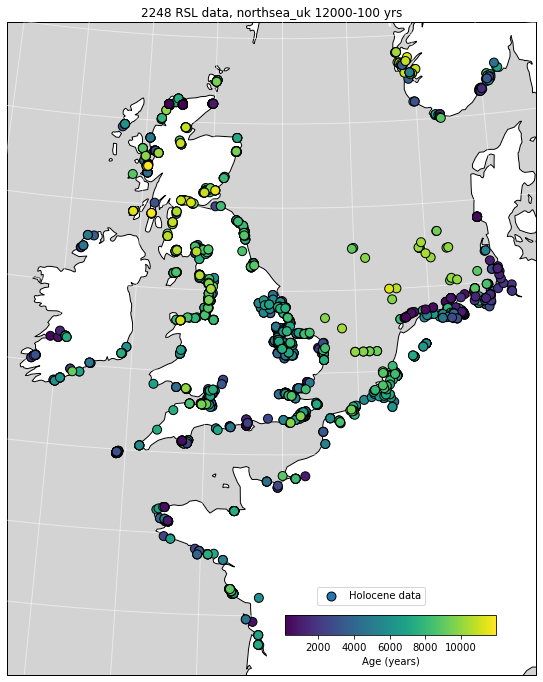

In [4]:
def add_sub_region_box(ax, locs, place, fc):
    """ """
    site = locs[place]
    geom = geometry.box(minx=site[0], maxx=site[1], miny=site[2], maxy=site[3])
    ax.add_geometries([geom], 
                      crs=ccrs.PlateCarree(), 
                      edgecolor=fc,
                      linewidth=3,
                      facecolor='none',
                      alpha=0.8, 
                      zorder=6)
    return ax

def add_features(ax):
    """ """
    ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')
    ax.add_feature(ocean_50m, color='lightgray', zorder=0)
    ax.add_feature(land_50m, color='white', zorder=1)
    ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)
    ax.coastlines(resolution='50m')
    return ax


projection = ccrs.LambertConformal(central_longitude=0)
trans = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=projection))

add_features(ax)

# add_sub_region_box(ax, locs, 'north_england', north_england)
# add_sub_region_box(ax, locs, 'denmark_netherlands', denmark_netherlands)
# add_sub_region_box(ax, locs, 'english_channel', english_channel)
# add_sub_region_box(ax, locs, 'northsea_uk_tight', northsea_uk_tight)


scat = ax.scatter(df_place.lon, df_place.lat, s=80, c = df_place.age, 
                  cmap='viridis', edgecolor='k', linewidths=1, 
                  transform=trans, zorder=5, label='Holocene data')

# scat2 = ax.scatter(df_lig.lon, df_lig.lat, s=80, c = 'r', 
#                    edgecolor='k', linewidths=1, 
#                   transform=trans, zorder=5, label='LIG data')

cbaxes = inset_axes(ax, width="40%", height="3%", loc=4, borderpad=4,) 
cbar = fig.colorbar(scat, ax=ax, cax=cbaxes, shrink=.5,
                    label='Age (years)', 
                   orientation='horizontal')

ax.set_title(f'{len(df_place)} RSL data, {place} {tmax}-{tmin} yrs')
ax.legend(loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.3, 0.5));

# fig.savefig('/Users/rogercreel/Desktop/dataplot_fennoscandia')

To Do: 
Make GPR models of all Ice6g, Lev, and Lev + Patton models for this region
for: 

1.  All of data
2.  Regional subsets (SW UK + NW France; Lowlands; Denmark) 
3.  Only data around LIG data constraints (concentric expansions) 

# Visualize outputs

In [44]:
class ClusterOutput():
    
    def __init__(self, place, ice_model, lith):
        self.place = place
        self.ice_model = ice_model
        self.lith = lith
        
    def dataset(self, path):
        return xr.open_mfdataset(path, combine='nested', concat_dim=['model'])
    
    def path(self, output, synth=None):
        if synth is not None:
            output_dir = synth
        else:
            output_dir = 'output'
            
        return glob.glob(f'{output_dir}/*{self.place}*{self.ice_model}*{self.lith}*{output}*')
    
    def load(self, output, synth=None, df=None):
        if synth is None:
            path = self.path(output)
        else:
            path = self.path(output, synth=synth)
            
        output = self.dataset(path)
        return output
    
param_files = glob.glob(f'synth_output/{place}*{ice_model}*{lith}*params.csv')
metric_files = glob.glob(f'synth_output/{place}*{ice_model}*{lith}*metrics.csv')

df_params = pd.concat((read_csv(f) for f in param_files), ignore_index=True)
df_mets = pd.concat((pd.read_csv(f) for f in metric_files), ignore_index=True)    

class ClusterDataframe():
    
    def __init__(self, place, ice_model, lith):
        self.place = place
        self.ice_model = ice_model
        self.lith = lith
        
    def dataset(self, path):
        return xr.open_mfdataset(path, combine='nested', concat_dim=['model'])
    
    def path(self, output, synth=None):
        if synth is not None:
            output_dir = synth
        else:
            output_dir = 'output'
            
        return glob.glob(f'{output_dir}/*{self.place}*{self.ice_model}*{self.lith}*{output}*')
    
    def load(self, output, synth=None, df=None):
        if synth is None:
            path = self.path(output)
        else:
            path = self.path(output, synth=synth)
            
        output = self.dataset(path)
        return output
    
    
place = 'english_channel'# 'denmark_netherlands'
ice_model = 'glac1d'
lith = 'l96C'
modelloader = ClusterOutput(place, ice_model, lith)
# ds_var = modelloader.load('var')
# ds_zp = modelloader.load('zp')
# ds_gia = modelloader.load('gia')
# ds_post = modelloader.load('post')
ds_var = modelloader.load('var', 'synth_output')
ds_zp = modelloader.load('zp', 'synth_output')
ds_gia = modelloader.load('gia', 'synth_output')
ds_post = modelloader.load('post', 'synth_output')

ValueError: No objects to concatenate

## Interpolate 'true' gia model to locations for synthetic test

In [103]:
ds_select??

Signature: ds_select(ds, row)
Source:   
def ds_select(ds, row):

    """ Slice GIA or GPR xarray dataset by rows in RSL pandas dataframe for rsl."""

    return ds.rsl.sel(age=[row.age],
                      lon=[row.lon],
                      lat=[row.lat],
                      method='nearest').squeeze().values
File:      ~/ws/EU_LIG/rcc_notebooks/eu_functions.py
Type:      function


In [104]:
ds_true

<xarray.Dataset>
Dimensions:   (age: 121, lat: 50, lon: 50, model: 0)
Coordinates:
  * lon       (lon) float64 2.11 2.354 2.598 2.842 ... 13.33 13.57 13.82 14.06
  * age       (age) int64 12000 11900 11800 11700 11600 ... 400 300 200 100 0
  * lat       (lat) float64 50.18 50.34 50.49 50.65 ... 57.42 57.58 57.73 57.89
    modelrun  (model) <U21 
Dimensions without coordinates: model
Data variables:
    rsl       (model, age, lon, lat) float64 dask.array<chunksize=(0, 121, 50, 50), meta=np.ndarray>

In [85]:
# choose arbitrary true model
ds_true = ds_gia.sel(model=ds_gia.modelrun =='glac1d_l96C_ump4_lm10')
df_place['rsl_giatrue'] = df_place.apply(lambda row: ds_select(ds_true, row), axis=1) 

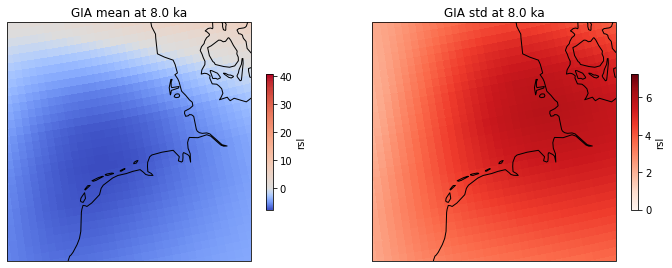

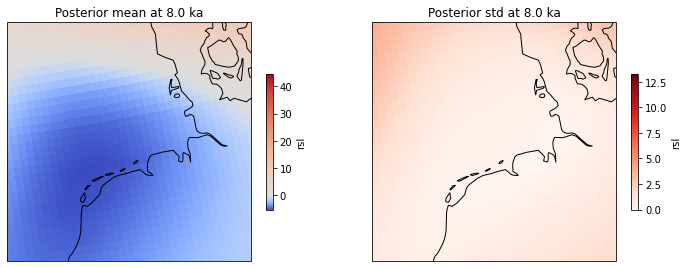

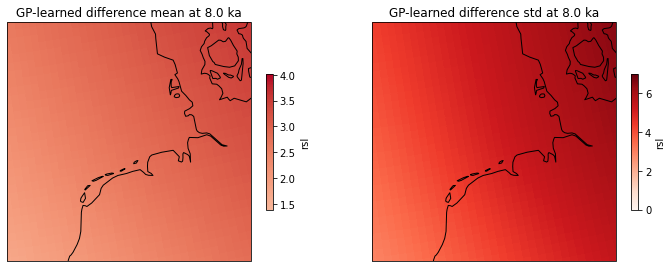

In [15]:
# make plotting convenience functions

def plot_fig(title, ds, age, topscale=0, bottomscale=0):
    proj = ccrs.LambertConformal(central_longitude=-10)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), subplot_kw=dict(projection=proj))
    ax = ax.flatten()
    
    ax[0].coastlines(resolution='50m')
    ax[0].set_extent(locs[place])
    mean = ds.mean(dim='model').load().rsl.sel(age=age, method='nearest')
    std = ds.std(dim='model').load().rsl.sel(age=age, method='nearest')
    
    if ds.equals(ds_gia):
        mean = mean.transpose()
        std = std.transpose()
             
    vmin = mean.min().values + bottomscale
    vmax = mean.max().values - topscale
    
    mean.plot(ax=ax[0],
              transform=ccrs.PlateCarree(), 
              cmap='coolwarm',
              norm = MidpointNormalize(vmin, vmax, 0),
             cbar_kwargs={'shrink': 0.5})
    
    ax[0].set_title(f'{title} mean at {age/1000} ka') 
    
    
    ax[1].coastlines(resolution='50m')
    ax[1].set_extent(locs[place])  
    
    vmin = std.min().values
    vmax = std.max().values
    
    std.plot(ax=ax[1],
             transform=ccrs.PlateCarree(), 
             cmap='Reds',
             vmin=0,
#              vmax=vmax,
             cbar_kwargs={'shrink': 0.5}
            )
    
    ax[1].set_title(f'{title} std at {age/1000} ka')    
    
    return 

plot_fig('GIA', ds_gia, 8000, topscale=0, bottomscale=0)
plot_fig('Posterior', ds_post, 8000, topscale=0, bottomscale=0)
plot_fig('GP-learned difference', ds_zp, 8000, topscale=0, bottomscale=0)

# Find largest likelihood

In [28]:

# def make_heatmap(df, ice_model, lith, values):
    
#     heatmap = df.sort_values(by=['um', 'lm']).pivot_table(index='um', columns='lm', values=values)

#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#     if values == 'likelihood':
#         cmap='viridis'
#     else:
#         cmap='viridis_r'
#     sns.heatmap(heatmap,  cmap=cmap, ax=ax,
#                 cbar_kws={'label': f'{values}'})

#     ax.set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model} : {lith} km lithosphere \n {values}')
#     plt.show()
    
# df_96 = df_plt[df_plt.lith == 'l96C']
# df_71 = df_plt[df_plt.lith == 'l71C']
    
# make_heatmap(df_96, 'd6g_h6g_', '96', 'likelihood')
# make_heatmap(df_71, 'd6g_h6g_', '71', 'likelihood')

# other =  'root mean squared error' # 'weighted residual sum of squares' #
# make_heatmap(df_96, 'd6g_h6g_', '96', other)
# make_heatmap(df_71, 'd6g_h6g_', '71', other )

In [ ]:
#%%%%%%%%%%%%%%%%%%% Read in files %%%%%%%%%%%%%%%%%%%%%%# 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def read_csv(f):
    df = pd.read_csv(f)
    df['k'] = ['k1', 'k2', 'k3', 'k4', 'k5']
    return df

def get_likes(place, ice_model, lith):
    
    param_files = glob.glob(f'synth_output/*{place}*{ice_model}*{lith}*params.csv')
    metric_files = glob.glob(f'synth_output/*{place}*{ice_model}*{lith}*metrics.csv')
    
    df_params = pd.concat((read_csv(f) for f in param_files), ignore_index=True)
    df_mets = pd.concat((pd.read_csv(f) for f in metric_files), ignore_index=True)
    
    return df_params, df_mets

df_params, df_mets = get_likes(place, ice_model, lith)
    
#%%%%%%%%%%%% Find largest likelihood  %%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def choose_bestmods(df):
    like = df[df.log_marginal_likelihood == df.log_marginal_likelihood.max()].modelrun.values[0]
    rmse = df[df['root mean squared error'] == df['root mean squared error'].min()].modelrun.values[0]
    return like, rmse

largestlike, bestrmse = choose_bestmods(df_mets)

#%%%%%%%%%%% Prepare names for heatmap %%%%%%%%%%%%%%# 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def splitNames(df):

    df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
    df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
    df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
    df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]
    df.lm = df.lm.astype(float)
    df.um = df.um.astype(float)
    
    return df

df_plt = splitNames(df_mets)
df_plt['likelihood'] = - df_plt.log_marginal_likelihood


#%%%%%%%%%%%% compare RMSE to ML %%%%%%%%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

places = ['northsea_uk_tight', ]
colors = [northsea_uk_tight]

fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True)
# plt.title(f'{place} {tmax} - {tmin} yrs \n {ice_model}: Log marginal likelihood vs. RMSE');

_, df_mets = get_likes(places[0], ice_model, lith)

ax.scatter(df_mets.log_marginal_likelihood, df_mets['root mean squared error'], c='k')
ax.set_ylabel('RMSE', fontsize=20)
ax.yaxis.set_label_position("right")
#     ax[i].yaxis.tick_right()
ax.tick_params(direction='out', length=6, width=2, colors='k',
           grid_color='r', grid_alpha=0.5, labelsize=16)
plt.setp(ax.spines.values(), color=colors[0], linewidth=2)

# ax[0].set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model}: Log marginal likelihood vs. RMSE', fontsize=16)
ax.set_xlabel('Log Marginal Likelihood', fontsize=20)
    
#%%%%%%%%%%%%%%%%%%% Make heatmaps %%%%%%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def heatmap(df, ice_model, lith, measure, ax):
    
    heatmap = df.sort_values(by=['um', 'lm']).pivot_table(index='um', columns='lm', values=measure)
    
    if 'likelihood' in measure:
        cmap='viridis'
    else:
        cmap='viridis_r'
    
    return sns.heatmap(heatmap,  cmap=cmap, ax=ax, cbar_kws={'label': f'{measure}'})
    

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
df_params, df_mets = get_likes(places[0], ice_model, lith) 
largestlike, bestrmse = choose_bestmods(df_mets)
df_plt = splitNames(df_mets)
df_plt['likelihood'] = - df_plt.log_marginal_likelihood

measure='log_marginal_likelihood'

hm = heatmap(df_plt, ice_model, lith, measure, ax)
hm.figure.axes[-1].set_ylabel('Likelihood', size=16)

for _, spine in hm.spines.items():
    spine.set_visible(True)
    spine.set_edgecolor(colors[0])
    spine.set_linewidth(3)

ax.set_ylabel('Upper Mantle Viscosity (10e21 Pa s)', fontsize=10)


#     ax.set(xlabel='')


ax.tick_params(direction='out', length=6, width=2, colors='k',
       grid_color='r', grid_alpha=0.5, labelsize=10)

ax.set_xlabel('Lower Mantle Viscosity (10e20 Pa s)', fontsize=10)
    

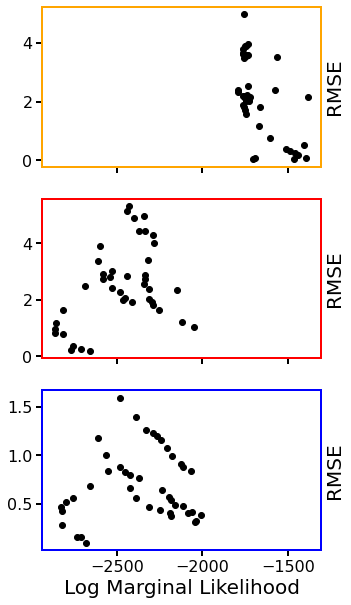

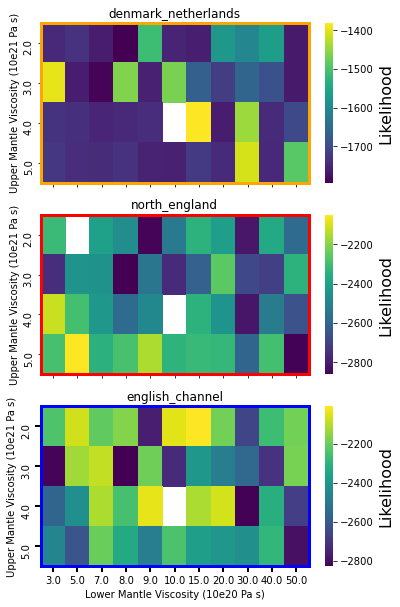

In [95]:
#%%%%%%%%%%%%%%%%%%% Read in files %%%%%%%%%%%%%%%%%%%%%%# 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def read_csv(f):
    df = pd.read_csv(f)
    df['k'] = ['k1', 'k2', 'k3', 'k4', 'k5']
    return df

def get_likes(place, ice_model, lith):
    
    param_files = glob.glob(f'synth_output/*{place}*{ice_model}*{lith}*params.csv')
    metric_files = glob.glob(f'synth_output/*{place}*{ice_model}*{lith}*metrics.csv')
    
    df_params = pd.concat((read_csv(f) for f in param_files), ignore_index=True)
    df_mets = pd.concat((pd.read_csv(f) for f in metric_files), ignore_index=True)
    
    return df_params, df_mets

# df_params, df_mets = get_likes(place, ice_model, lith)
    
#%%%%%%%%%%%% Find largest likelihood  %%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def choose_bestmods(df):
    like = df[df.log_marginal_likelihood == df.log_marginal_likelihood.max()].modelrun.values[0]
    rmse = df[df['root mean squared error'] == df['root mean squared error'].min()].modelrun.values[0]
    return like, rmse

# largestlike, bestrmse = choose_bestmods(df_mets)

#%%%%%%%%%%% Prepare names for heatmap %%%%%%%%%%%%%%# 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def splitNames(df):

    df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
    df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
    df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
    df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]
    df.lm = df.lm.astype(float)
    df.um = df.um.astype(float)
    
    return df

# df_plt = splitNames(df_mets)
# df_plt['likelihood'] = - df_plt.log_marginal_likelihood


#%%%%%%%%%%%% compare RMSE to ML %%%%%%%%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

places = ['denmark_netherlands', 'north_england', 'english_channel', ]
colors = [denmark_netherlands, north_england, english_channel]

fig, ax = plt.subplots(3, 1, figsize=(5,10), sharex=True)
ax = ax.flatten()
# plt.title(f'{place} {tmax} - {tmin} yrs \n {ice_model}: Log marginal likelihood vs. RMSE');
for i, place in enumerate(places):
    _, df_mets = get_likes(place, ice_model, lith)
    
    ax[i].scatter(df_mets.log_marginal_likelihood, df_mets['root mean squared error'], c='k')
    ax[i].set_ylabel('RMSE', fontsize=20)
    ax[i].yaxis.set_label_position("right")
#     ax[i].yaxis.tick_right()
    ax[i].tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5, labelsize=16)
    plt.setp(ax[i].spines.values(), color=colors[i], linewidth=2)

# ax[0].set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model}: Log marginal likelihood vs. RMSE', fontsize=16)
ax[2].set_xlabel('Log Marginal Likelihood', fontsize=20)
    
#%%%%%%%%%%%%%%%%%%% Make heatmaps %%%%%%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def heatmap(df, ice_model, lith, measure, ax):
    
    heatmap = df.sort_values(by=['um', 'lm']).pivot_table(index='um', columns='lm', values=measure)
    
    if 'likelihood' in measure:
        cmap='viridis'
    else:
        cmap='viridis_r'
    
    return sns.heatmap(heatmap,  cmap=cmap, ax=ax, cbar_kws={'label': f'{measure}'})
    

fig, ax = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
ax=ax.flatten()

for i, place in enumerate(places):
    
    df_params, df_mets = get_likes(place, ice_model, lith) 
    largestlike, bestrmse = choose_bestmods(df_mets)
    df_plt = splitNames(df_mets)
    df_plt['likelihood'] = - df_plt.log_marginal_likelihood
    
    measure='log_marginal_likelihood'
    
    hm = heatmap(df_plt, ice_model, lith, measure, ax[i])
    hm.figure.axes[-1].set_ylabel('Likelihood', size=16)

    for _, spine in hm.spines.items():
        spine.set_visible(True)
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(3)
    
    ax[i].set_ylabel('Upper Mantle Viscosity (10e21 Pa s)', fontsize=10)
    ax[i].set_title(f'{place}')

    if i < 2:
        ax[i].set(xlabel='')

    else:
        ax[i].tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5, labelsize=10)
        
        ax[i].set_xlabel('Lower Mantle Viscosity (10e20 Pa s)', fontsize=10)
        


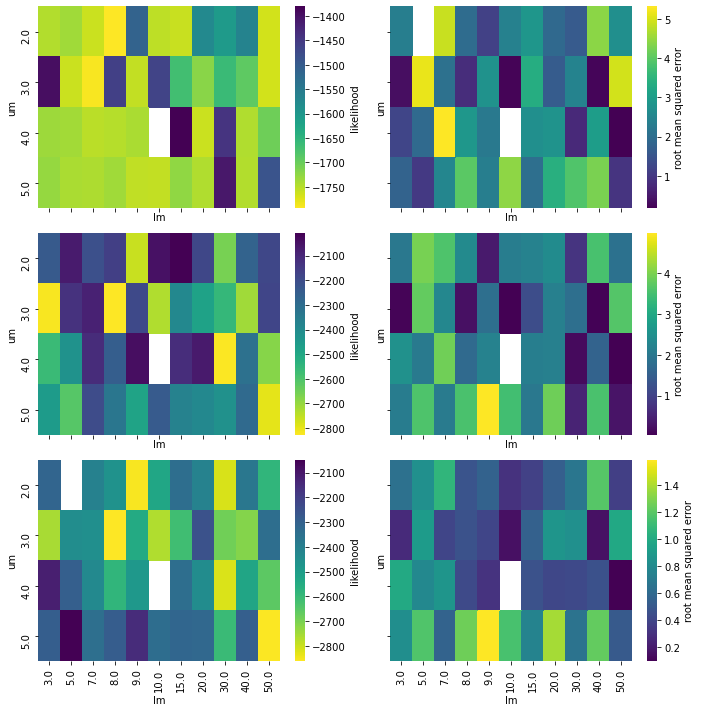

In [108]:
def heatmap(df, ice_model, lith, measure, ax):
    
    heatmap = df.sort_values(by=['um', 'lm']).pivot_table(index='um', columns='lm', values=measure)
    
    if 'likelihood' in measure:
        cmap='viridis_r'
    else:
        cmap='viridis'
    
    return sns.heatmap(heatmap,  cmap=cmap, ax=ax, cbar_kws={'label': f'{measure}'})
    

fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
ax=ax.flatten()

for i, place in enumerate(places + places):
    
    df_params, df_mets = get_likes(place, ice_model, lith)
    
    largestlike, bestrmse = choose_bestmods(df_mets)
    
    df_plt = splitNames(df_mets)
    df_plt['likelihood'] = df_plt.log_marginal_likelihood
    
    if i%2 == 0:
        measure = 'likelihood'
    else:
        measure = 'root mean squared error'
    
    heatmap(df_plt, ice_model, lith, measure, ax[i])
    
plt.tight_layout()

# Plot timeseries

In [102]:
site[1].

,lat,lon,rsl,rsl_er_max,rsl_er_min,age,age_er_max,age_er_min,rsl_er,age_er,rsl_giatrue,location,locnum
1922,48.6,-1.79,0.032,5.902,5.902,2952.0,257.0,201.0,5.902,229.0,[],english_channel,english_channel_site0
1967,48.6,-1.79,-2.889,5.902,5.902,4950.0,347.0,324.0,5.902,335.5,[],english_channel,english_channel_site0
1968,48.6,-1.79,-3.069,5.902,5.902,5012.0,304.0,359.0,5.902,331.5,[],english_channel,english_channel_site0
1971,48.6,-1.79,-4.089,5.902,5.902,5067.0,369.0,237.0,5.902,303.0,[],english_channel,english_channel_site0
1978,48.6,-1.79,-3.159,5.902,5.902,5452.0,260.0,398.0,5.902,329.0,[],english_channel,english_channel_site0
1982,48.6,-1.79,-4.374,5.902,5.902,5561.0,314.0,244.0,5.902,279.0,[],english_channel,english_channel_site0
1984,48.6,-1.79,-4.454,5.902,5.902,5612.0,279.0,287.0,5.902,283.0,[],english_channel,english_channel_site0
1987,48.6,-1.79,-3.904,5.902,5.902,5712.0,212.0,238.0,5.902,225.0,[],english_channel,english_channel_site0
1990,48.6,-1.79,-4.064,5.902,5.902,5779.0,211.0,192.0,5.902,201.5,[],english_channel,english_channel_site0
1994,48.6,-1.79,-4.679,5.902,5.902,6082.0,216.0,313.0,5.902,264.5,[],english_channel,english_channel_site0


In [99]:
#%%%%%%%%%%%%%% find best GIA models   %%%%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

def find_largestlike_model(which, largestlike):
    files = glob.glob(f'output/*{which}')
    matching = [s for s in files if largestlike in s]
    return xr.open_dataset(matching[0])

#%%%%%%% find prior and posterior of largest likelihood  %%%%%%%%%%%%#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

ds_gialargestlike = find_largestlike_model('prior', largestlike)
ds_postlargestlike = find_largestlike_model('posterior', largestlike)
ds_zplargestlike = find_largestlike_model('zp', largestlike)

#%%%%%%%%%%%% find prior and posterior of smallest RMSE %%%%%%%%%%%%#
ds_gialargestrmse = find_largestlike_model('prior', bestrmse)
ds_postlargestrmse = find_largestlike_model('posterior', bestrmse)


projection = ccrs.PlateCarree()
# trans = ccrs.AlbersEqualArea(central_longitude=40)
trans = ccrs.LambertConformal(central_longitude=-10)

colormark = ['blue', 'chocolate', 'darkred', 'crimson', 'olivedrab']

number=16

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()


def interp_ds(ds):
    return ds.interp(age=ds_giamean.age, lat=ds_giamean.lat, lon=ds_giamean.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(tmax, tmin)).squeeze()


### Plot  #####

fig, ax = plt.subplots(1,len(nufsamp), figsize=(20, 6), subplot_kw=dict(projection=projection))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_gia.rsl[0,:,:,0])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
#     ax[i].set_extent([-12, 25, 47, 72])
    ax[i].set_extent(extent)

    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=projection)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=projection,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False, transform=projection)

    ax[i].set_title('')

    
fig, ax = plt.subplots(1, len(nufsamp), figsize=(24, 6))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
#     #slice data for each site
    prior = slice_dataset(ds_gia) 

    post = slice_dataset(ds_post)
    var = slice_dataset(np.sqrt(ds_var))
    top = post + var * 2
    bottom = post - var * 2
    
    site_err = 2 * (site[1].rsl_er)
    age_err = 2 * site[1].age_er
    
    giabestlike = slice_dataset(ds_gialargestlike)
    postbestlike = slice_dataset(ds_postlargestlike)
    
    giabestrmse = slice_dataset(ds_gialargestrmse)
    postbestrmse = slice_dataset(ds_postlargestrmse)    
    
    prior.plot.line(ax=ax[i], 
                    x='age', 
                    color=colormark[0], 
                    alpha=0.1, 
                    add_legend=False);
    
    giabestlike.plot.line(ax=ax[i], color=colormark[0], lw=2, ls='-', label='prior maximum likelihood')
    giabestrmse.plot.line(ax=ax[i], color=colormark[0], lw=2, ls='--', label='prior lowest rmse')

#     ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[3], alpha=0.4) 
    
    post.plot.line(ax=ax[i],
                   x='age',
                   color=colormark[1],
                   alpha=0.1, 
                   add_legend=False);

    postbestlike.plot.line(ax=ax[i],
                           color='k',
                           lw=2, 
                           ls='-', 
                           label='best posterior likelihood')
    postbestrmse.plot.line(ax=ax[i], 
                           color='k',
                           lw=2,
                           ls='--',
                           label='best posterior rmse'
                          )
    
#     ax[i].scatter(site[1].age, 
#                   site[1].rsl, 
#                   c=colormark[2],
#                   s=4, 
#                   lw=2,
#                   label='RSL data'
#                  )
    ax[i].scatter(site[1].age, 
                  site[1].rsl_giatrue, 
                  c=colormark[2],
                  s=4, 
                  lw=2,
                  label='RSL data'
                 )
    ax[i].errorbar(site[1].age, 
                   site[1].rsl, 
                   yerr=site_err,
                   xerr=age_err, 
                   c=colormark[2],
                   fmt='none', 
                   capsize=-.1,
                   lw=1.5
                  )

    ax[i].set_xlim(0, 12000)
    ax[i].set_ylim(site[1].rsl.min() - 20,site[1].rsl.max()+10)
    ax[i].set_title('')


# Set legend outside frame 
# see https://stackoverflow.com/questions/30413789/matplotlib-automatic-legend-outside-plot
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.gcf().canvas.draw()
invFigure = plt.gcf().transFigure.inverted()

lgd_pos = lgd.get_window_extent()
lgd_coord = invFigure.transform(lgd_pos)
lgd_xmax = lgd_coord[1, 0]

ax_pos = plt.gca().get_window_extent()
ax_coord = invFigure.transform(ax_pos)
ax_xmax = ax_coord[1, 0]

shift = 1 - (lgd_xmax - ax_xmax)
plt.gcf().tight_layout(rect=(0, 0, shift, 1))

plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20, y=1.02)

plt.tight_layout()

ValueError: setting an array element with a sequence.

Error in callback <function flush_figures at 0x11a880048> (for post_execute):


KeyboardInterrupt: 

# Explore hyperparameters

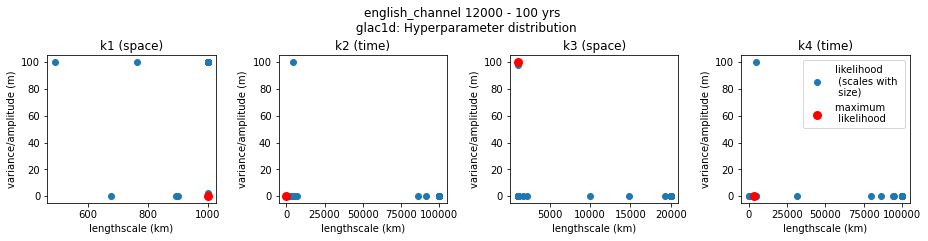

In [22]:
def get_k(df_params, k_it):
    return df_params[df_params['k'] == k_it]

def maxlike(k):
    return k[k.model == largestlike]
    

ks = ['k1', 'k2', 'k3', 'k4']
parenth = ['space', 'time', 'space', 'time']

fig, ax = plt.subplots(1, 4, figsize=(13, 3))
ax = ax.flatten()
for i, ax in enumerate(ax):
    k = get_k(df_params, ks[i])
    ml = maxlike(k)
    
    ax.scatter(k.lengthscale, 
               k.variance,
              label='likelihood \n (scales with \n size)')
    ax.scatter(ml.lengthscale, 
               ml.variance, 
               c='r', 
               lw=3,
               label='maximum \n likelihood')
    ax.set_xlabel('lengthscale (km)')
    ax.set_ylabel('variance/amplitude (m)')
    ax.set_title(f'{ks[i]} ({parenth[i]})')

plt.legend()
plt.tight_layout()
plt.suptitle(f'{place} {tmax} - {tmin} yrs \n {ice_model}: Hyperparameter distribution', y=1.1);

# Make Heatmaps

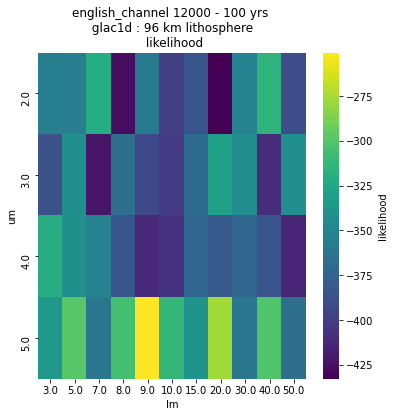

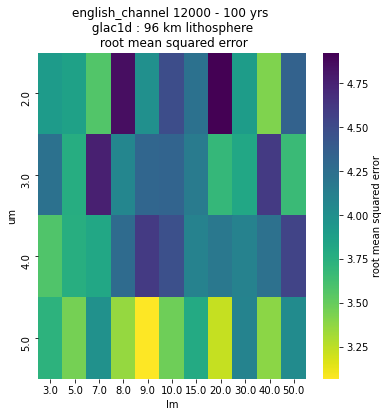

In [27]:
def splitNames(df):

    df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
    df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
    df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
    df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]
    df.lm = df.lm.astype(float)
    df.um = df.um.astype(float)
    
    return df

df_plt = splitNames(df_mets)
df_plt['likelihood'] = df_plt.log_marginal_likelihood

def make_heatmap(df, ice_model, lith, values):
    
    heatmap = df.pivot_table(index='um', columns='lm', values=values)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    if values == 'likelihood':
        cmap='viridis'
    else:
        cmap='viridis_r'
    sns.heatmap(heatmap,  cmap=cmap, ax=ax,
                cbar_kws={'label': f'{values}'})

    ax.set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model} : {lith} km lithosphere \n {values}')
    plt.show()
    
# def plot_heatmap(df, ice_model, other):
#     if df.lith.str.contains('l96C').any():
#         df_96 = df[df.lith == 'l96C']
#         make_heatmap(df_96, ice_model, 'l96C', )
        
#     if df.lith.str.contains('l71C').any():
#         df_71 = df[df.lith == 'l71C']
#         make_heatmap(df_71, ice_model, 'l71C')

    
df_96 = df_plt[df_plt.lith == 'l96C']
# df_71 = df_plt[df_plt.lith == 'l71C']
    
make_heatmap(df_96, ice_model, '96', 'likelihood')
# make_heatmap(df_71, 'd6g_h6g_', '71', 'likelihood')

other =  'root mean squared error' # 'weighted residual sum of squares' #
make_heatmap(df_96, ice_model, '96', other)
# make_heatmap(df_71, 'd6g_h6g_', '71', other )


In [ ]:
# Load data

ds_varp = xr.open_dataset(glob.glob('output/*variance')[0])
ds_zp = xr.open_dataset(glob.glob('output/*zp')[0]).rename({'__xarray_dataarray_variable__':'rsl'}) #remove when fixed as dataset
ds_giamean = xr.open_dataset(glob.glob('output/*prior')[0])
ds_priorplusgpr = xr.open_dataset(glob.glob('output/*posterior')[0])

In [ ]:
proj = ccrs.PlateCarree()

colormark = ['blue', 'chocolate', 'darkred', 'crimson', 'olivedrab']
cmaps = cmap_codes('viridis', len(df_nufsamps))


number=11

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()

def interp_ds(ds):
    return ds.interp(age=ds_giamean.age, lat=ds_giamean.lat, lon=ds_giamean.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(tmax, tmin))


###### Plot  #####

fig, ax = plt.subplots(1,len(nufsamp), figsize=(20, 6), subplot_kw=dict(projection=projection))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_giamean.rsl[:,:,0])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].set_extent(extent)
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=trans)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=trans,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False)

    ax[i].set_title('')

    
num = 6
fig, ax = plt.subplots(1, len(nufsamp), figsize=(20, 6))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20)

#     #slice data for each site
    prior_it = slice_dataset(ds_giamean) 

    post_it = slice_dataset(ds_priorplusgpr)
    var_it = slice_dataset(np.sqrt(ds_varp))
    top = post_it + var_it * 2
    bottom = post_it - var_it * 2
    
    site_err = 2 * (site[1].rsl_er)
    age_err = 2 * site[1].age_er

    prior_it.plot(ax=ax[i], c=colormark[0], alpha=1, label='ICE6G GIA prior')


    ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[3], alpha=0.4) 
    post_it.plot(ax=ax[i], lw=2, c=colormark[1], alpha=1, label='ICE6G GPR posterior')

    
    ax[i].scatter(site[1].age, site[1].rsl, c=colormark[2], s=4, lw=2,label='RSL data')
    ax[i].errorbar(site[1].age, site[1].rsl, yerr=site_err, xerr=age_err, c=colormark[2], fmt='none', capsize=-.1,lw=1.5)

    ax[i].set_xlim(0, 12000)
    ax[i].set_ylim(site[1].rsl.min() - 20,site[1].rsl.max()+10)
    ax[i].set_title('')
#     if i > num:
#         break

lines = [ Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
         Circle([0], 0.1, color=colormark[2], linewidth=3, ec="none")]

labels = ['ICE6G GIA prior', 'ICE6G GPR posterior', 'RSL data']
ax[i].legend(lines, labels, loc='lower left')


plt.show()